### 70. 単語ベクトルの和による特徴量
#### 目的
ニュース記事の見出しを、学習済みの単語ベクトルを使って、数値のベクトル表現に変換する  

In [2]:
import os
import numpy as np
import gensim.downloader as api
import re

# 学習済み単語ベクトルの読み込み
model = api.load("word2vec-google-news-300")
d = model.vector_size  # 300 次元

# ファイルのカテゴリに合わせたマッピング
label_mapping = {
    "b": 0,  # Business
    "t": 1,  # Science/Technology
    "e": 2,  # Entertainment
    "m": 3   # Health
}

def tokenize(text):
    # 単語を抽出
    return re.findall(r"\w+", text)

def create_dataset(file_path):
    X_list = []
    Y_list = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                category, headline = line.split("\t")
            except ValueError:
                continue
            tokens = tokenize(headline)
            vecs = []
            for token in tokens:
                if token in model:
                    vecs.append(model[token])
            if len(vecs) == 0:
                # 警告表示（トークンが全く見つからない場合）
                print("Warning: No valid tokens found for headline:", headline)
                avg_vec = np.zeros(d)
            else:
                avg_vec = np.mean(vecs, axis=0)
            # カテゴリが label_mapping に含まれているかチェック
            if category in label_mapping:
                X_list.append(avg_vec)
                Y_list.append(label_mapping[category])
            else:
                # 該当しないカテゴリの場合はその行をスキップ
                print("Skipping unknown category:", category)
    if len(X_list) == 0:
        raise ValueError("No valid feature vectors were generated. Check your file format and tokenization.")
    X = np.vstack(X_list)  # shape (n, d)
    Y = np.array(Y_list)   # shape (n,)
    return X, Y

# ファイルパスは適宜調整してください
X_train, Y_train = create_dataset("train.txt")
X_valid, Y_valid = create_dataset("valid.txt")
X_test,  Y_test  = create_dataset("test.txt")

# 作成したデータを保存
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)
np.save("X_valid.npy", X_valid)
np.save("Y_valid.npy", Y_valid)
np.save("X_test.npy", X_test)
np.save("Y_test.npy", Y_test)

print("特徴量行列とラベルベクトルを保存しました。")


Skipping unknown category: 210723
特徴量行列とラベルベクトルを保存しました。


### 71. 単層ニューラルネットワークによる予測
### 目的 
先ほど作成した特徴量を入力として、単層のニューラルネットワーク（線形層＋softmax）を使い、各記事のカテゴリ予測の確率を出力する

In [4]:
import torch
import torch.nn.functional as F

# NumPy から PyTorch テンソルに変換
X_train = torch.tensor(np.load("X_train.npy"), dtype=torch.float32)
Y_train = torch.tensor(np.load("Y_train.npy"), dtype=torch.long)
d = X_train.shape[1]  # 300
L = 4  # カテゴリ数

# ランダム初期化された重み行列 W ∈ ℝ^(300×4)
W = torch.randn(d, L, requires_grad=True)

# 最初の4事例の特徴量をまとめた行列 X[1:4] ∈ ℝ^(4×300)
X_sample = X_train[:4]  # shape: (4, 300)

# 線形変換と softmax
logits = X_sample @ W  # shape: (4, 4)
Y_hat = F.softmax(logits, dim=1)
print("【タスク71】サンプル事例の予測確率:")
print(Y_hat)


【タスク71】サンプル事例の予測確率:
tensor([[0.0264, 0.1660, 0.7305, 0.0771],
        [0.1062, 0.0186, 0.8479, 0.0273],
        [0.1008, 0.1275, 0.7622, 0.0095],
        [0.2550, 0.2481, 0.2333, 0.2637]], grad_fn=<SoftmaxBackward0>)


### 72. 損失と勾配の計算
#### 目的
学習する際に、モデルの出力と正解ラベルとの間の誤差（損失）を計算し、その損失に基づいてモデルのパラメータをどの方向に更新すべきかを知るために、勾配を求める

In [6]:
# 例として、サンプル事例（最初の4件）について正解ラベルを取得
y_true = Y_train[:4]  # shape: (4,)

# 損失計算（クロスエントロピー損失）
loss = F.cross_entropy(logits, y_true)
print("【タスク72】サンプル損失:", loss.item())

# 勾配計算
loss.backward()
# 正しい形状になっているか確認(𝑑×𝐿)
print("【タスク72】重み W の勾配の形状:", W.grad.shape)


【タスク72】サンプル損失: 2.4065873622894287
【タスク72】重み W の勾配の形状: torch.Size([300, 4])


### 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD）は、データ全体の平均ではなく、1件または少数のデータ（ミニバッチ）ごとにパラメータを更新する手法

In [8]:
import torch.optim as optim

# 単層モデルを nn.Linear で定義（バイアスなし、タスク71と同じ）
model_linear = torch.nn.Linear(d, L, bias=False)
# 重み初期化（ランダム）
torch.nn.init.normal_(model_linear.weight, mean=0.0, std=0.01)

# 損失関数とオプティマイザ（SGD）
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_linear.parameters(), lr=0.1)

n_epochs = 100

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model_linear(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        pred = outputs.argmax(dim=1)
        acc = (pred == Y_train).float().mean().item()
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Accuracy: {acc*100:.2f}%")
        
print("【タスク73】SGD による学習完了。")


Epoch [10/100], Loss: 1.2997, Accuracy: 76.61%
Epoch [20/100], Loss: 1.2232, Accuracy: 77.47%
Epoch [30/100], Loss: 1.1618, Accuracy: 77.70%
Epoch [40/100], Loss: 1.1115, Accuracy: 77.88%
Epoch [50/100], Loss: 1.0695, Accuracy: 77.88%
Epoch [60/100], Loss: 1.0339, Accuracy: 77.93%
Epoch [70/100], Loss: 1.0032, Accuracy: 77.81%
Epoch [80/100], Loss: 0.9765, Accuracy: 77.81%
Epoch [90/100], Loss: 0.9529, Accuracy: 77.76%
Epoch [100/100], Loss: 0.9319, Accuracy: 77.69%
【タスク73】SGD による学習完了。


### 74. 正解率の計測

In [10]:
# 学習データでの正解率
with torch.no_grad():
    outputs_train = model_linear(X_train)
    preds_train = outputs_train.argmax(dim=1)
    acc_train = (preds_train == Y_train).float().mean().item()

# 評価データを読み込み
X_test = torch.tensor(np.load("X_test.npy"), dtype=torch.float32)
Y_test = torch.tensor(np.load("Y_test.npy"), dtype=torch.long)
with torch.no_grad():
    outputs_test = model_linear(X_test)
    preds_test = outputs_test.argmax(dim=1)
    acc_test = (preds_test == Y_test).float().mean().item()

print("【タスク74】正解率:")
print(f"  Training Accuracy: {acc_train*100:.2f}%")
print(f"  Test Accuracy: {acc_test*100:.2f}%")


【タスク74】正解率:
  Training Accuracy: 77.69%
  Test Accuracy: 78.54%


### 75. 損失と正解率のプロット

Epoch 10: Train Loss 1.2975, Train Acc 75.75%, Valid Loss 1.2868, Valid Acc 77.44%
Epoch 20: Train Loss 1.2211, Train Acc 77.21%, Valid Loss 1.2100, Valid Acc 78.79%
Epoch 30: Train Loss 1.1598, Train Acc 77.55%, Valid Loss 1.1482, Valid Acc 79.01%
Epoch 40: Train Loss 1.1096, Train Acc 77.78%, Valid Loss 1.0974, Valid Acc 79.01%
Epoch 50: Train Loss 1.0678, Train Acc 77.79%, Valid Loss 1.0549, Valid Acc 79.09%
Epoch 60: Train Loss 1.0323, Train Acc 77.83%, Valid Loss 1.0188, Valid Acc 79.16%
Epoch 70: Train Loss 1.0017, Train Acc 77.84%, Valid Loss 0.9876, Valid Acc 79.31%
Epoch 80: Train Loss 0.9751, Train Acc 77.75%, Valid Loss 0.9604, Valid Acc 79.31%
Epoch 90: Train Loss 0.9516, Train Acc 77.76%, Valid Loss 0.9364, Valid Acc 79.31%
Epoch 100: Train Loss 0.9307, Train Acc 77.69%, Valid Loss 0.9150, Valid Acc 79.31%


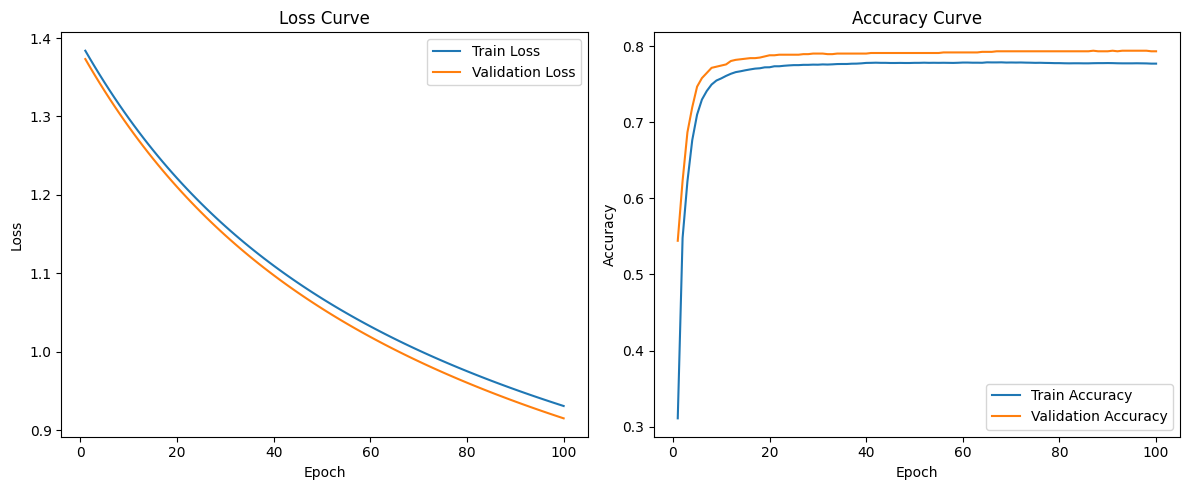

In [12]:
import matplotlib.pyplot as plt

# 検証データもテンソルに変換
X_valid = torch.tensor(np.load("X_valid.npy"), dtype=torch.float32)
Y_valid = torch.tensor(np.load("Y_valid.npy"), dtype=torch.long)

n_epochs = 100
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# 新たにモデルを初期化（ここでは単層モデル）
model_linear = torch.nn.Linear(d, L, bias=False)
torch.nn.init.normal_(model_linear.weight, mean=0.0, std=0.01)
optimizer = optim.SGD(model_linear.parameters(), lr=0.1)

for epoch in range(n_epochs):
    model_linear.train()
    optimizer.zero_grad()
    outputs_train = model_linear(X_train)
    loss_train = criterion(outputs_train, Y_train)
    loss_train.backward()
    optimizer.step()
    
    # 訓練時の評価
    with torch.no_grad():
        preds_train = outputs_train.argmax(dim=1)
        acc_train = (preds_train == Y_train).float().mean().item()
        
        # 検証データでの評価
        model_linear.eval()
        outputs_valid = model_linear(X_valid)
        loss_valid = criterion(outputs_valid, Y_valid)
        preds_valid = outputs_valid.argmax(dim=1)
        acc_valid = (preds_valid == Y_valid).float().mean().item()
    
    train_losses.append(loss_train.item())
    valid_losses.append(loss_valid.item())
    train_accuracies.append(acc_train)
    valid_accuracies.append(acc_valid)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Train Loss {loss_train.item():.4f}, Train Acc {acc_train*100:.2f}%, Valid Loss {loss_valid.item():.4f}, Valid Acc {acc_valid*100:.2f}%")

# プロット
epochs = range(1, n_epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, valid_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


### 76. チェックポイント
#### 目的
長時間の学習中に、ある時点のモデルの状態（パラメータや最適化の状態）を保存しておくことで、途中で学習が中断しても再開できるようにする

In [14]:
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

n_epochs = 50
for epoch in range(n_epochs):
    model_linear.train()
    optimizer.zero_grad()
    outputs_train = model_linear(X_train)
    loss_train = criterion(outputs_train, Y_train)
    loss_train.backward()
    optimizer.step()
    
    # チェックポイント保存
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    torch.save(model_linear.state_dict(), checkpoint_path)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Checkpoint saved to {checkpoint_path}")



Epoch 10: Checkpoint saved to checkpoints/model_epoch_10.pt
Epoch 20: Checkpoint saved to checkpoints/model_epoch_20.pt
Epoch 30: Checkpoint saved to checkpoints/model_epoch_30.pt
Epoch 40: Checkpoint saved to checkpoints/model_epoch_40.pt
Epoch 50: Checkpoint saved to checkpoints/model_epoch_50.pt


### 77. ミニバッチ化
#### 目的
すべての事例に対して一度に計算するのではなく、少数の事例（ミニバッチ）ごとに損失と勾配を計算してパラメータ更新を行うことで、学習効率を向上させる


In [16]:
import time
batch_sizes = [1, 2, 4, 8]
epoch_times = {}

for B in batch_sizes:
    model_linear = torch.nn.Linear(d, L, bias=False)
    torch.nn.init.normal_(model_linear.weight, mean=0.0, std=0.01)
    optimizer = optim.SGD(model_linear.parameters(), lr=0.1)
    n_samples = X_train.shape[0]
    indices = torch.randperm(n_samples)
    
    start_time = time.time()
    for i in range(0, n_samples, B):
        batch_idx = indices[i:i+B]
        X_batch = X_train[batch_idx]
        Y_batch = Y_train[batch_idx]
        
        optimizer.zero_grad()
        outputs = model_linear(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
    elapsed = time.time() - start_time
    epoch_times[B] = elapsed
    print(f"Batch size {B}: Time per epoch = {elapsed:.4f} sec")

print("【タスク77】各ミニバッチサイズでのエポック時間:", epoch_times)


Batch size 1: Time per epoch = 0.5867 sec
Batch size 2: Time per epoch = 0.3509 sec
Batch size 4: Time per epoch = 0.1710 sec
Batch size 8: Time per epoch = 0.0907 sec
【タスク77】各ミニバッチサイズでのエポック時間: {1: 0.5867011547088623, 2: 0.3509399890899658, 4: 0.1709918975830078, 8: 0.09070110321044922}


### 78. GPU上での学習
macにも対応させるためmpsも使用できるか確認

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

# データを GPU に移動
X_train_gpu = X_train.to(device)
Y_train_gpu = Y_train.to(device)
X_valid_gpu = X_valid.to(device)
Y_valid_gpu = Y_valid.to(device)

# モデルを GPU に移動
model_linear = torch.nn.Linear(d, L, bias=False).to(device)
torch.nn.init.normal_(model_linear.weight, mean=0.0, std=0.01)
optimizer = optim.SGD(model_linear.parameters(), lr=0.1)

n_epochs = 50
for epoch in range(n_epochs):
    model_linear.train()
    optimizer.zero_grad()
    outputs = model_linear(X_train_gpu)
    loss = criterion(outputs, Y_train_gpu)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            preds = outputs.argmax(dim=1)
            acc = (preds == Y_train_gpu).float().mean().item()
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}, Accuracy {acc*100:.2f}%")
        
print("【タスク78】GPU 上での学習完了。")


Using device: mps
Epoch 10: Loss 1.2997, Accuracy 76.19%
Epoch 20: Loss 1.2228, Accuracy 77.34%
Epoch 30: Loss 1.1611, Accuracy 77.68%
Epoch 40: Loss 1.1107, Accuracy 77.85%
Epoch 50: Loss 1.0687, Accuracy 77.89%
【タスク78】GPU 上での学習完了。


### 79. 多層ニューラルネットワーク

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
        super(DeepNet, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# 例として、3層の隠れ層（それぞれ100, 50, 25ユニット）を持つネットワーク
hidden_dims = [100, 50, 25]
model_deep = DeepNet(d, hidden_dims, L).to(device)

# オプティマイザや学習ループを設定して学習を行う
optimizer = torch.optim.SGD(model_deep.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

n_epochs = 100
for epoch in range(n_epochs):
    model_deep.train()
    optimizer.zero_grad()
    outputs = model_deep(X_train_gpu)
    loss = criterion(outputs, Y_train_gpu)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            preds = outputs.argmax(dim=1)
            acc = (preds == Y_train_gpu).float().mean().item()
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}, Train Acc {acc*100:.2f}%")

print("Training completed.")


Epoch 10: Loss 1.0158, Train Acc 63.17%
Epoch 20: Loss 0.7580, Train Acc 74.93%
Epoch 30: Loss 0.6588, Train Acc 77.45%
Epoch 40: Loss 0.6002, Train Acc 78.86%
Epoch 50: Loss 0.5567, Train Acc 79.99%
Epoch 60: Loss 0.5335, Train Acc 81.02%
Epoch 70: Loss 0.5024, Train Acc 82.18%
Epoch 80: Loss 0.4801, Train Acc 82.87%
Epoch 90: Loss 0.4653, Train Acc 83.69%
Epoch 100: Loss 0.4544, Train Acc 84.13%
Deep network training completed.
